<a href="https://colab.research.google.com/github/amirrezasokhankhosh/Tic-Tac-Toe-Rinforcement-Learning/blob/main/Tic_Tac_Toe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Meeting 1 : Formalizing The Problem
Environment : Simple Tic-tac-toe game.\
Goal : Winning the game.\
Actions : choosing a grid from unchoosed grids.\
Reward : For each win, draw, loose, the agent will get 1, 0, -1, respectively.\
States : Each grid in gridworld of our problem has 3 possibilities, chose by enemy or us or It's not chosen yet, hense we have 3 ^ 9 states.

# Meeting 2 : Choosing The Learning Algorithm.
1. Can we represent the value function with a table? No.
2. Are we using average reward? No.
3. Will we learn on each timestep? Yes.
4. Is this a control problem? Yes.\
So we are now down to choose between 3 algorithms : Expected SARSA, Q Learning and SARSA. We use SARSA in this problem.

# Meeting 3 : Agent Architecture Meeting : Overview of Design Choices
## Metaparameter Choices
### Which Function Approximator Will We Use?
Neural Network.
#### Which Activation Function Will We Use?
\begin{align}
        \text{f}(x) = \left\{
        \begin{array}{cl}
        x & x > 0 \\
        0
        \end{array}
        \right.
    \end{align}
#### How Are We Going to Train The Neural Network?
We are going to use the ADAM optimizer.
### Which Exploration Method Will We Use?
Softmax Policy.





In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving agent.py to agent.py
Saving environment.py to environment.py
User uploaded file "agent.py" with length 2041 bytes
User uploaded file "environment.py" with length 1830 bytes


In [4]:
# Required Packages

import numpy as np
import matplotlib.pyplot as plt
from environment import BaseEnvironment
from BaseOptimizer import BaseOptimizer
from agent import BaseAgent
from copy import deepcopy
import random

In [5]:
class Adam(BaseOptimizer):
    def __init__(self):
        pass

    def optimizer_init(self, optimizer_info):
        """Setup for the optimizer.

        Set parameters needed to setup the Adam algorithm.

        Assume optimizer_info dict contains:
        {
            num_states: integer,
            num_hidden_layer: integer,
            num_hidden_units: integer,
            step_size: float,
            self.beta_m: float
            self.beta_v: float
            self.epsilon: float
        }
        """

        self.num_states = optimizer_info.get("num_states")
        self.num_hidden_layer = optimizer_info.get("num_hidden_layer")
        self.num_hidden_units = optimizer_info.get("num_hidden_units")

        # Specify Adam algorithm's hyper parameters
        self.step_size = optimizer_info.get("step_size")
        self.beta_m = optimizer_info.get("beta_m")
        self.beta_v = optimizer_info.get("beta_v")
        self.epsilon = optimizer_info.get("epsilon")

        self.layer_size = np.array([self.num_states, self.num_hidden_units, 1])

        # Initialize Adam algorithm's m and v
        self.m = [dict() for i in range(self.num_hidden_layer + 1)]
        self.v = [dict() for i in range(self.num_hidden_layer + 1)]

        for i in range(self.num_hidden_layer + 1):
            # Initialize self.m[i]["W"], self.m[i]["b"], self.v[i]["W"], self.v[i]["b"] to zero
            self.m[i]["W"] = np.zeros((self.layer_size[i], self.layer_size[i + 1]))
            self.m[i]["b"] = np.zeros((1, self.layer_size[i + 1]))
            self.v[i]["W"] = np.zeros((self.layer_size[i], self.layer_size[i + 1]))
            self.v[i]["b"] = np.zeros((1, self.layer_size[i + 1]))

        # Initialize beta_m_product and beta_v_product to be later used for computing m_hat and v_hat
        self.beta_m_product = self.beta_m
        self.beta_v_product = self.beta_v

    def update_weights(self, weights, g):
        """
        Given weights and update g, return updated weights
        """

        for i in range(len(weights)):
            for param in weights[i].keys():
                # update self.m and self.v
                self.m[i][param] = self.beta_m * self.m[i][param] + (1 - self.beta_m) * g[i][param]
                self.v[i][param] = self.beta_v * self.v[i][param] + (1 - self.beta_v) * (g[i][param] * g[i][param])

                # compute m_hat and v_hat
                m_hat = self.m[i][param] / (1 - self.beta_m_product)
                v_hat = self.v[i][param] / (1 - self.beta_v_product)

                # update weights
                weights[i][param] += self.step_size * m_hat / (np.sqrt(v_hat) + self.epsilon)

        # update self.beta_m_product and self.beta_v_product
        self.beta_m_product *= self.beta_m
        self.beta_v_product *= self.beta_v

        return weights


In [6]:
# Tic-Tac-Toe Environment

class TicTacToeEnvironment(BaseEnvironment):
    def __init__(self):
        pass

    def env_init(self, env_info={}):
        """
        Setup for the environment called when the experiment first starts.
        """
        # initialize board
        self.board = np.zeros((3, 3))

    def env_start(self):
        """
        The first method called when the experiment starts, called before the
        agent starts.

        Returns:
            The first state observation from the environment.
        """

        reward = 0.0
        self.board = np.zeros((3, 3))
        state = np.zeros((3, 3))
        actions = self.find_actions(state)
        observation = (state, actions)
        is_terminal = False

        self.reward_obs_term = (reward, observation, is_terminal)

        # return first state observation from the environment
        return self.reward_obs_term[1]

    def env_step(self, action):
        """A step taken by the environment.

        Args:
            action: The action taken by the agent

        Returns:
            (float, state, Boolean): a tuple of the reward, state observation,
                and boolean indicating if it's terminal.
        """

        self.take_action(action)
        self.take_action_opp()
        state = np.copy(self.board)
        actions = self.find_actions(state)
        observation = (state, actions)
        reward, is_terminal = self.get_reward()

        self.reward_obs_term = (reward, observation, is_terminal)

        return self.reward_obs_term

    def find_actions(self, state):
        actions = []
        for i in range(0, 3, 1):
            for j in range(0, 3, 1):
                if state[i, j] == 0:
                    actions.append((i, j))
        return actions

    def get_board(self):
        return self.board

    def set_board(self, board):
        self.board = board

    def take_action(self, action):
        """
            0 represents none chosen grid.
            1 represents agent action.
            2 represents opponent action.
        """
        self.board[int(action[0]), int(action[1])] = 1
        
    def take_action_opp(self):
        possible_actions = self.find_actions(np.copy(self.board))
        if len(possible_actions) != 0:
            action = random.choice(possible_actions)
            self.board[int(action[0]), int(action[1])] = 2

    def get_reward(self):
        """
            Win : 10
            Draw : 0
            Loose : -10
            Each time step : -1
        """
        reward = -1
        is_terminal = False
        if np.count_nonzero(self.board) == 9:
            is_terminal = True
        for x in self.board:
            if np.array_equal(x, np.ones(3)):
                reward += 10
                is_terminal = True
                return reward, is_terminal
            elif np.array_equal(x, np.full(3, 2)):
                reward += -10
                is_terminal = True
                return reward, is_terminal
        for x in self.board.T:
            if np.array_equal(x, np.ones(3)):
                reward += 10
                is_terminal = True
                return reward, is_terminal
            elif np.array_equal(x, np.full(3, 2)):
                reward += -10
                is_terminal = True
                return reward, is_terminal
        if np.array_equal(np.diagonal(self.board), np.full(3, 1)) or np.array_equal(np.fliplr(self.board).diagonal(),
                                                                                    np.full(3, 1)):
            reward += 10
            is_terminal = True
            return reward, is_terminal
        elif np.array_equal(np.diagonal(self.board), np.full(3, 2)) or np.array_equal(np.fliplr(self.board).diagonal(),
                                                                                      np.full(3, 2)):
            reward += -10
            is_terminal = True
            return reward, is_terminal
        return reward, is_terminal

In [7]:
class StateValueNetwork:
    def __init__(self, network_config):
        # number of states
        self.num_states = network_config.get("num_states")
        # number of hidden layers
        self.num_hidden_layer = network_config.get("num_hidden_layer")
        # number of hidden units
        self.num_hidden_units = network_config.get("num_hidden_units")
        # discount
        self.discount = network_config['gamma']
        
        self.rand_generator = np.random.RandomState(network_config.get("seed"))
        
        # layer size : NN
        self.layer_size = np.array([self.num_states, self.num_hidden_units, 1])
    
        # Initialize the neural network's parameter
        self.weights = [dict() for i in range(self.num_hidden_layer + 1)]
        for i in range(self.num_hidden_layer + 1):
            ins, outs = self.layer_size[i], self.layer_size[i + 1]
            self.weights[i]['W'] = self.rand_generator.normal(0, np.sqrt(2 / ins), (ins, outs))
            self.weights[i]['b'] = self.rand_generator.normal(0, np.sqrt(2 / ins), (1, outs))
    
    def get_value(self, s):
        """
        Compute value of input s given the weights of a neural network
        """
        
        # DONE!
        
        psi = self.my_matmul(s, self.weights[0]["W"]) + self.weights[0]["b"]
        x = np.maximum(psi, 0)
        v = self.my_matmul(x, self.weights[1]["W"]) + self.weights[1]["b"]
        
        return v
    
    def get_gradient(self, s):
        """
        Given inputs s and weights, return the gradient of v with respect to the weights
        """
        
        # DONE!
        
        grads = [dict() for i in range(len(self.weights))]
        x = np.maximum(self.my_matmul(s, self.weights[0]["W"]) + self.weights[0]["b"], 0)
        grads[0]["W"] = self.my_matmul(s.T, (self.weights[1]["W"].T * (x > 0)))
        grads[0]["b"] = self.weights[1]["W"].T * (x > 0)
        grads[1]["W"] = x.T
        grads[1]["b"] = 1

        return grads
    
    
    def get_action_values(self, observation):
        # find values of each next state
        state = observation[0]
        possible_actions = observation[1]
        
        q_values = np.zeros((len(possible_actions), 2))
        
        for i in range(len(possible_actions)):
            temp = state
            temp[possible_actions[i][0], possible_actions[i][1]] = 1
            state_vec = self.one_hot(self.generate_hash(temp), self.num_states)
            v_s = self.get_value(state_vec)
            action = 3 * possible_actions[i][0] + possible_actions[i][1]
            
            # POSSIBLE FAULT    
            q_values[i] = (action, -1 + self.discount * v_s)
        
        return q_values 
    
    
    def one_hot(self, state, num_states):
        """
        Given num_state and a state, return the one-hot encoding of the state
        """

        # DONE!
        
        one_hot_vector = np.zeros((1, num_states))
        one_hot_vector[0, int((state - 1))] = 1
        
        return one_hot_vector
    
    def generate_hash(self, m):
        my_hash = 0
        for i in range(0, 3, 1):
            for j in range(0, 3, 1):
                my_hash = my_hash * 3 + int(m[i][j])
        return my_hash

    def my_matmul(self, x1, x2):
        """
        Given matrices x1 and x2, return the multiplication of them
        """
        
        result = np.zeros((x1.shape[0], x2.shape[1]))
        x1_non_zero_indices = x1.nonzero()
        if x1.shape[0] == 1 and len(x1_non_zero_indices[1]) == 1:
            result = x2[x1_non_zero_indices[1], :]
        elif x1.shape[1] == 1 and len(x1_non_zero_indices[0]) == 1:
            result[x1_non_zero_indices[0], :] = x2 * x1[x1_non_zero_indices[0], 0]
        else:
            result = np.matmul(x1, x2)
        return result
    
    def get_weights(self):
        """
        Returns: 
            A copy of the current weights of this network.
        """
        return deepcopy(self.weights)
    
    def set_weights(self, weights):
        """
        Args: 
            weights (list of dictionaries): Consists of weights that this network will set as its own weights.
        """
        self.weights = deepcopy(weights)

In [8]:
class Agent(BaseAgent):
    def __init__(self):
        self.name = "expected_sarsa_agent"

    def agent_init(self, agent_config):

        # DONE!

        """Setup for the agent called when the experiment first starts.

        Set parameters needed to setup the agent.

        Assume agent_config dict contains:
        {
            optimizer_config: dictionary : {
                "num_states",
                "num_hidden_layer",
                "num_hidden_units",
                "step_size",
                "beta_m",
                "beta_v",
                "epsilon"},
            network_config : dictionary : {
                "num_states",
                "num_hidden_layer",
                "num_hidden_units",
                "discount_factor"
            }
            discount_factor: float,
        }
        """
        self.rand_generator = np.random.RandomState(agent_config.get("seed"))

        # optimizer
        self.optimizer = Adam()
        self.optimizer.optimizer_init(agent_config["optimizer_config"])
        # network
        self.network = StateValueNetwork(agent_config["network_config"])
        # discount
        self.discount = agent_config['gamma']
        # tau
        self.tau = agent_config['tau']
        # number of states
        self.num_states = agent_config.get("num_states")
        # number of hidden layers : NN
        self.num_hidden_layer = agent_config.get("num_hidden_layer")
        # number of hidden units : NN
        self.num_hidden_units = agent_config.get("num_hidden_units")

        # layer size : NN
        self.layer_size = np.array([self.num_states, self.num_hidden_units, 1])

        # Initialize the neural network's parameter
        self.weights = [dict() for i in range(self.num_hidden_layer + 1)]
        for i in range(self.num_hidden_layer + 1):
            ins, outs = self.layer_size[i], self.layer_size[i + 1]
            self.weights[i]['W'] = self.rand_generator.normal(0, np.sqrt(2 / ins), (ins, outs))
            self.weights[i]['b'] = self.rand_generator.normal(0, np.sqrt(2 / ins), (1, outs))

        self.last_observation = None
        self.last_action = None

        self.sum_rewards = 0
        self.episode_steps = 0

    def policy(self, observation):

        # DONE!

        """
        Args:
            state (Numpy array): the state.
        Returns:
            the action.
        """
        action_values = self.network.get_action_values(observation)
        probs_batch = self.softmax(action_values, self.tau)
        try:
            index = self.rand_generator.choice(len(observation[1]), p=probs_batch[:, 1].squeeze())
        except:
            index = 0
        action_num = action_values[index, 0]
        y = action_num % 3
        x = action_num // 3
        return (x, y)

    def agent_start(self, observation):

        # DONE!

        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (Numpy array): the state from the
                environment's evn_start function.
        Returns:
            The first action the agent takes.
        """
        self.sum_rewards = 0
        self.episode_steps = 0
        self.last_observation = (np.copy(observation[0]), observation[1])
        self.last_action = self.policy(self.last_observation)
        return self.last_action

    def agent_step(self, reward, observation):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (Numpy array): the state from the
                environment's step based, where the agent ended up after the
                last step
        Returns:
            The action the agent is taking.
        """
        self.sum_rewards += reward
        self.episode_steps += 1

        # Delta for expected sarsa
        last_state_hash = self.network.generate_hash(self.last_observation[0])
        last_state_vec = self.network.one_hot(last_state_hash, self.num_states)
        last_value = self.network.get_value(last_state_vec)

        state_hash = self.network.generate_hash(np.copy(observation[0]))
        state_vec = self.network.one_hot(state_hash, self.num_states)
        value = self.network.get_value(state_vec)

        delta = reward + self.discount * value - last_value

        grads = self.network.get_gradient(last_state_vec)

        g = [dict() for i in range(self.num_hidden_layer + 1)]
        for i in range(self.num_hidden_layer + 1):
            for param in self.weights[i].keys():
                g[i][param] = delta * grads[i][param]

        weights = self.optimizer.update_weights(self.weights, g)

        self.network.set_weights(weights)

        # Select action
        action = self.policy((np.copy(observation[0]), observation[1]))

        # Update the last state and last action.
        self.last_observation = (np.copy(observation[0]), observation[1])
        self.last_action = action

        return (int(action[0]), int(action[1]))

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        self.sum_rewards += reward
        self.episode_steps += 1

        last_state_hash = self.network.generate_hash(self.last_observation[0])
        last_state_vec = self.network.one_hot(last_state_hash, self.num_states)
        last_value = self.network.get_value(last_state_vec)
        delta = reward - last_value

        grads = self.network.get_gradient(last_state_vec)

        g = [dict() for i in range(self.num_hidden_layer + 1)]
        for i in range(self.num_hidden_layer + 1):
            for param in self.weights[i].keys():
                g[i][param] = delta * grads[i][param]

        weights = self.optimizer.update_weights(self.weights, g)

        self.network.set_weights(weights)

    def agent_message(self, message):
        if message == "get_sum_reward":
            return self.sum_rewards
        else:
            raise Exception("Unrecognized Message!")

    def softmax(self, action_values, tau=1.0):
        """
        Args:
            action_values (Numpy array): A 2D array of shape (batch_size, num_actions).
                        The action-values computed by an action-value network.
            tau (float): The temperature parameter scalar.
        Returns:
            A 2D array of shape (batch_size, num_actions). Where each column is a probability distribution over
            the actions representing the policy.
        """

        # Compute the preferences by dividing the action-values by the temperature parameter tau
        preferences = action_values[:, 1] / tau
        # Compute the maximum preference across the actions
        try: 
            max_preference = np.max(preferences)
        except:
            print(action_values)
            raise Error

        # Reshape max_preference array which has shape [Batch,] to [Batch, 1]. This allows NumPy broadcasting
        # when subtracting the maximum preference from the preference of each action.
        reshaped_max_preference = max_preference.reshape((-1, 1))

        # Compute the numerator, i.e., the exponential of the preference - the max preference.
        exp_preferences = np.exp(preferences - reshaped_max_preference)
        # Compute the denominator, i.e., the sum over the numerator along the actions axis.
        sum_of_exp_preferences = np.sum(exp_preferences)

        # Reshape sum_of_exp_preferences array which has shape [Batch,] to [Batch, 1] to  allow for NumPy broadcasting
        # when dividing the numerator by the denominator.
        reshaped_sum_of_exp_preferences = sum_of_exp_preferences.reshape((-1, 1))

        # Compute the action probabilities according to the equation in the previous cell.
        probs = exp_preferences / reshaped_sum_of_exp_preferences

        # squeeze() removes any singleton dimensions. It is used here because this function is used in the 
        # agent policy when selecting an action (for which the batch dimension is 1.) As np.random.choice is used in 
        # the agent policy and it expects 1D arrays, we need to remove this singleton batch dimension.
        probs = probs.squeeze()

        action_probs = np.zeros((len(action_values), 2))
        for i in range(len(action_probs)):
            action_probs[i, 0] = action_values[i, 0]
            try:
                action_probs[i, 1] = probs[i]
            except:
                action_probs[i, 1] = 1.0
        
        return action_probs

Progress : 0.0%.
Progress : 10.0%.
Progress : 20.0%.
Progress : 30.0%.
Progress : 40.0%.
Progress : 50.0%.
Progress : 60.0%.
Progress : 70.0%.
Progress : 80.0%.
Progress : 90.0%.


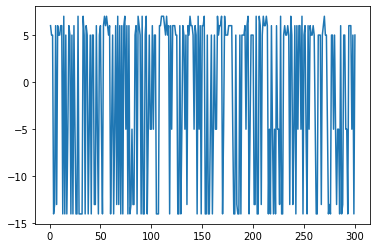

In [9]:
# Train

agent_config = {
    "optimizer_config" : {
        "num_states" : 3 ** 9,
        "num_hidden_layer" : 1,
        "num_hidden_units" : 3 ** 6,
        "step_size" : 3e-5,
        "beta_m": 0.9,
        "beta_v": 0.999,
        "epsilon": 1e-8
    },
    "network_config" : {
        "num_states" : 3 ** 9,
        "num_hidden_layer" : 1,
        "num_hidden_units" : 3 ** 6,
        'gamma': 0.99
    },
    "num_states" : 3 ** 9,
    "num_hidden_layer" : 1,
    "num_hidden_units" : 3 ** 6,
    'replay_buffer_size': 32,
    'minibatch_sz': 32,
    'num_replay_updates_per_step': 4,
    'gamma': 0.99,
    'tau': 1000.0,
    'seed': 0
}

rewards = np.zeros(300)

agent = Agent()
agent.agent_init(agent_config)

env = TicTacToeEnvironment()
env.env_init()
for i in range(len(rewards)):
    if i % 30 == 0:
        print("Progress : " + str(i / 3) + "%.")
    obs = env.env_start()
    action = agent.agent_start(obs)
    reward_obs_term = env.env_step(action)
    while reward_obs_term[2] != True:
        action = agent.agent_step(reward_obs_term[0], reward_obs_term[1])
        reward_obs_term = env.env_step(action)
    agent.agent_end(reward_obs_term[0])
    rewards[i] = agent.sum_rewards

x_axis = np.zeros(300)
for i in range(len(x_axis)):
    x_axis[i] = i + 1
plt.plot(x_axis, rewards)
plt.show()